In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns 
import math
import statistics
import random

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from collections import Counter

from pycytominer import normalize

In [2]:
def load_metadata(path):
    """
    Loads the csv or csv.gz file into a pandas df, providing unique ID.
    """
    df = pd.read_csv(path)
    
    # Seperate data and metadata
    metadata_cols = [i for i in df.columns if 'Metadata' in i]
    metadata = df[metadata_cols]
    data_cols = [i for i in df.columns if i not in metadata_cols]
    
    # Remove exclude features from the data df
    data_cols = [x for x in data_cols if x.find('Costes')<0 if x.find('Manders')<0 if x.find('RWC')<0]
    data = df[data_cols]
    
    # Use metadata to create the index
    metadata_df = metadata.copy()
    data_df = data.copy()
    metadata_df['my_id'] = metadata['Metadata_line_source'] + '_' + metadata['Metadata_line_condition'] + '_' + \
        metadata['Metadata_line_ID'].astype(str) + '_' + metadata['Metadata_well_position']
    data_df['my_id'] = metadata_df['my_id']
    data_df.set_index('my_id', inplace=True)
    print('df shape: {}'.format(data_df.shape))
    
#     Remove the extraneous 'control' or 'deletion' for the isogenic perturbs, to keep naming consistency.
    new_idx = data_df.index.tolist()
    new_idx = [i.split('_')[0]+'_'+ i.split('_')[1]+'_'+ i.split('_')[3]+'_' +i.split('_')[4] \
               if 'genic' in i else i for i in new_idx]
    
    data_df.index = new_idx
    return metadata_df

In [5]:
from pathlib import Path
path = os.getcwd()
base_dir = str(Path(path).parent)

metadata = load_metadata(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized.csv.gz')
metadata = metadata[['Metadata_Well', 'my_id']]

data = pd.read_csv(base_dir + '/1.run-workflows/profiles/NCP_PROGENITORS_1_BRANCHING/BR_NCP_PROGENITORS_1.csv.gz')
data_cols = [x for x in data.columns if x.find('Costes')<0 if x.find('Manders')<0 if x.find('RWC')<0]
data = data[data_cols]
data = normalize(data)
data = pd.merge(data, metadata, left_on='Metadata_Well', right_on='Metadata_Well')

data = data.drop(['Metadata_Plate', 'Metadata_Well'], axis=1)
data.set_index('my_id', inplace=True)

#     Remove the extraneous 'control' or 'deletion' for the isogenic perturbs, to keep naming consistency.
new_idx = data.index.tolist()
new_idx = [i.split('_')[0]+'_'+ i.split('_')[1]+'_'+ i.split('_')[3]+'_' +i.split('_')[4] \
           if 'genic' in i else i for i in new_idx]

data.index = new_idx

data['group'] = data.index.str.split('_').map(lambda x: x[1])

human_only=True
if human_only:
    data = data[data.index.str.contains('human')]

df shape: (384, 4023)


[Text(0, 0.5, 'TotalObjectSkeletonLength')]

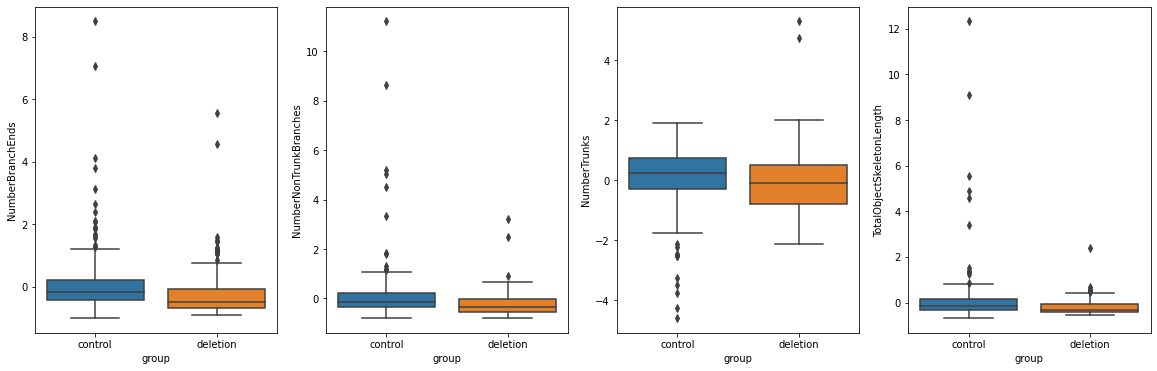

In [26]:
fig, axes = plt.subplots(1,4, figsize=(20,6))
sns.boxplot(x='group', y='Nuclei_ObjectSkeleton_NumberBranchEnds_CellBodiesPlusNeuritesSkel', data=data, ax=axes[0]).set(ylabel='NumberBranchEnds')
sns.boxplot(x='group', y='Nuclei_ObjectSkeleton_NumberNonTrunkBranches_CellBodiesPlusNeuritesSkel', data=data, ax=axes[1]).set(ylabel='NumberNonTrunkBranches')
sns.boxplot(x='group', y='Nuclei_ObjectSkeleton_NumberTrunks_CellBodiesPlusNeuritesSkel', data=data, ax=axes[2]).set(ylabel='NumberTrunks')
sns.boxplot(x='group', y='Nuclei_ObjectSkeleton_TotalObjectSkeletonLength_CellBodiesPlusNeuritesSkel', data=data, ax=axes[3]).set(ylabel='TotalObjectSkeletonLength')


In [28]:
data.mean()

Cells_Children_CellBodiesPlusNeurites_Count                                   0.000000
Cells_Children_Cytoplasm_Count                                                0.000000
Cells_Children_Neurites_Count                                                 0.000000
Cells_Location_Center_X                                                      -0.007068
Cells_Location_Center_Y                                                       0.019277
Cells_Location_Center_Z                                                       0.000000
Cells_Number_Object_Number                                                    0.059338
Cells_Parent_Nuclei                                                           0.059338
Cytoplasm_Location_Center_X                                                  -0.007005
Cytoplasm_Location_Center_Y                                                   0.019261
Cytoplasm_Number_Object_Number                                                0.059338
Cytoplasm_Parent_Cells                     